# Single Leptoquark Analysis
This document  is an introductory pyroot notebook for the selection of leptoquarks produced in a VBF-Like signal, where the dominant channel turns out to be of the form

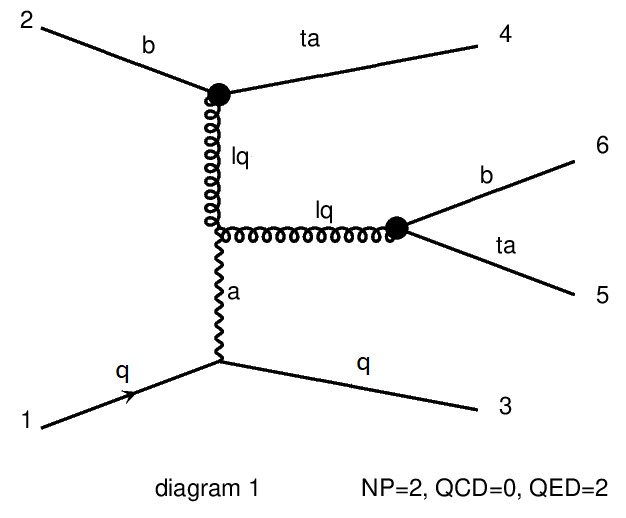

Assuming that tau leptons decay in a hadronic way, we will have a signal with 4 jets, two of them are τ-jets, one of them is a bjet and a light-jet.

In [ ]:
import os   
import ROOT
from ROOT import *

Welcome to JupyROOT 6.25/01
/mnt/d/MadFolder/lq_mzp500_mlq500


Due to the extensive size of the dataset generated in delphes, we have added a parameter that allows you to choose whether to run the analysis on a small part of the dataset for code testing (`False`) or on the entire dataset for statistical analysis (`True`).


In [ ]:
dir_path = os.path.abspath('')
fullAnalysis = True
print(dir_path)

The information of the events generated in each madgraph run is stored in the `Events` folder. The following script makes a reading of how many runs are inside `Events`.

In [ ]:
jobs=0
dir_name = os.getcwd() + "/Events"

#Read how many runs in /Events
if (fullAnalysis): 
    dirs = next(os.walk(dir_name))[1]
    jobs = len(dirs)
else: jobs=1


A TChain is declared for delphes and it is initialized with the output of each run in madgraph.

In [ ]:
tree = TChain("Delphes;1")
for ind in range(1,jobs+1):
    directory= str("Events/run_" + '%02d' % ind +"/tag_1_delphes_events.root")
    print("Run found in "+ directory)
    tree.Add(directory)
print("Total events uploaded: " + str(tree.GetEntries()))

Run found in Events/run_01/tag_1_delphes_events.root
Run found in Events/run_02/tag_1_delphes_events.root
Run found in Events/run_03/tag_1_delphes_events.root
Run found in Events/run_04/tag_1_delphes_events.root
Run found in Events/run_05/tag_1_delphes_events.root
Run found in Events/run_06/tag_1_delphes_events.root
Run found in Events/run_07/tag_1_delphes_events.root
Run found in Events/run_08/tag_1_delphes_events.root
Run found in Events/run_09/tag_1_delphes_events.root
Run found in Events/run_10/tag_1_delphes_events.root
218638


Warning in <TClass::Init>: no dictionary for class HepMCEvent is available
Warning in <TClass::Init>: no dictionary for class Event is available
Warning in <TClass::Init>: no dictionary for class Weight is available
Warning in <TClass::Init>: no dictionary for class GenParticle is available
Warning in <TClass::Init>: no dictionary for class SortableObject is available
Warning in <TClass::Init>: no dictionary for class Track is available
Warning in <TClass::Init>: no dictionary for class Tower is available
Warning in <TClass::Init>: no dictionary for class Jet is available
Warning in <TClass::Init>: no dictionary for class MissingET is available
Warning in <TClass::Init>: no dictionary for class Electron is available
Warning in <TClass::Init>: no dictionary for class Photon is available
Warning in <TClass::Init>: no dictionary for class Muon is available
Warning in <TClass::Init>: no dictionary for class ScalarHT is available


In the delphes output we can find the kinematic information of each jet which is stored in a TLorentzVector, in addition delphes makes a Tagging process which helps us identify the parton that has become in each jet.

We define a structure that is fed with this information and it has as parameters the relevant information of each  jet from the output of delphes.

In [ ]:
class JetVector():
    def __init__(self, event, j):
        self.TLV=TLorentzVector()
        self.TLV.SetPtEtaPhiM(
            event.GetLeaf("Jet.PT").GetValue(j), 
            event.GetLeaf("Jet.Eta").GetValue(j), 
            event.GetLeaf("Jet.Phi").GetValue(j), 
            event.GetLeaf("Jet.Mass").GetValue(j)
        )
        self.BTag   = event.GetLeaf("Jet.BTag").GetValue(j)
        self.TauTag = event.GetLeaf("Jet.TauTag").GetValue(j)


We define a function that has an event as input and extracts the information of all the jets in that event. In addition, it applies the kinematic cuts that allow us to define a good jet, *i.e.*, that the b-jets and tau-jets are within the fiducial region of the tracker (η < 2.5) and have enough transverse momentum (20 GeV for the τ-jets and 30GeV for the b-jets), and that the light-jets have a minimum moment of 30 GeV.

This function returns a sorted list per transverse moment for each type of jet.

In [ ]:
def PT(jet):
    return jet.TLV.Pt()

def getGoodJets(event):
    jets = []
    b_jets = []
    tau_jets = []
    all_jets = []
    other_jets=[]
    n_jets=event.Jet.GetEntries()
    for j in range(n_jets):
        jet=JetVector(event, j)
        #Discard all jets with pt less othan 20GeV 
        if not (jet.TLV.Pt()> 20.): continue

        #Classify by type jet according to its Tag
        #apply its corresponding kinematic cut.
        if( jet.BTag==0 and jet.TauTag==0):
            if (PT(jet)>30.0 ):
                jets.append(jet)
                all_jets.append(jet)
        elif( jet.BTag==1 and jet.TauTag==0): 
            if ( abs(jet.TLV.Eta())<2.5 and jet.TLV.Pt()>30.):
                b_jets.append(jet)
                all_jets.append(jet)
        elif( jet.BTag==0 and jet.TauTag==1): 
            if ( abs(jet.TLV.Eta())<2.5 ):
                tau_jets.append(jet)
                all_jets.append(jet)
        else: 
            other_jets.append(jet)
            all_jets.append(jet)
    jets.sort      ( reverse = True , key=PT )
    b_jets.sort    ( reverse = True , key=PT )
    tau_jets.sort  ( reverse = True , key=PT )
    all_jets.sort  ( reverse = True , key=PT )
    other_jets.sort( reverse = True , key=PT )
    return all_jets, jets, b_jets, tau_jets, other_jets

Now, we continue to define functions to evaluate the possible correlation between kinematic variables to the different jets.

In [ ]:
def DeltaR(v1,v2):
    return v1.TLV.DeltaR(v2.TLV)

def DeltaEta(v1,v2):
    return v1.TLV.Eta() - v2.TLV.Eta()

def DeltaPhi(v1,v2):
    return v1.TLV.DeltaPhi(v2.TLV)

def sDeltaPT(v1,v2):
    return PT(v1) - PT(v2)

def vDeltaPT(v1,v2):
    a=TVector2(v1.TLV.Px(),v1.TLV.Py())
    b=TVector2(v2.TLV.Px(),v2.TLV.Py())
    c=a-b
    return c.Mod()

def vDeltaP(v1,v2):
    a=TVector3(v1.TLV.Px(),v1.TLV.Py(),v1.TLV.Pz())
    b=TVector3(v2.TLV.Px(),v2.TLV.Py(),v2.TLV.Pz())
    c=a-b
    return c.Mag()

In [ ]:
canvas = TCanvas("Canvas","",800,600)
canvas.SetGrid()
cutflow = TH1F("Cutflow","Cutflow; Cut; Events",10,0,10)
hist_njets = TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10)
hist_m_LQ=TH1F("hist_m_LQ", "M_{b tau}", 1000, 0.0, 2000.0)

pt_all_jets=TH1F("pt_all_jets", "Pt_{allj}", 100, 0.0, 600.0)
eta_all_jets=TH1F("eta_all_jets", "#eta_{allj}", 100, -5, 5)
pt_all_jets.SetLineColor(kBlack)
eta_all_jets.SetLineColor(kBlack)

pt_lead_jets=TH1F("pt_lead_jets", "Pt_{j1}", 100, 0.0, 1000.0)
eta_lead_jets=TH1F("eta_lead_jets", "#eta_{j1}", 100, -5, 5)
pt_lead_jets.SetLineColor(kBlue)
eta_lead_jets.SetLineColor(kBlue)
pt_lead_bjets=TH1F("pt_lead_bjets", "Pt_{bj1}", 100, 0.0, 1000.0)
eta_lead_bjets=TH1F("eta_lead_bjets", "#eta_{bj2}", 100, -5, 5)
pt_lead_bjets.SetLineColor(kRed)
eta_lead_bjets.SetLineColor(kRed)
pt_lead_taus=TH1F("pt_lead_taus", "Pt_{tau1}", 100, 0.0, 1000.0)
eta_lead_taus=TH1F("eta_lead_taus", "#eta_tau1", 100, -5, 5)
pt_lead_taus.SetLineColor(kGreen)
eta_lead_taus.SetLineColor(kGreen)
pt_slead_taus=TH1F("pt_slead_taus", "Pt_tau2", 100, 0.0, 1000.0)
eta_slead_taus=TH1F("eta_slead_taus", "#eta_tau2", 100, -5, 5)
pt_slead_taus.SetLineColor(kViolet)
eta_slead_taus.SetLineColor(kViolet)

hist_deltar_taus=TH1F("deta_taus","#Delta R_{#tau_{1}#tau_{2}}",100,0,8) 
hist_deltar_b_ltau=TH1F("deltar_b_ltau","#Delta R_{b#tau_{1}}",100,0,8) 
hist_deltar_b_sltau=TH1F("deltar_b_sltau","#Delta R_{b#tau_{2}}",100,0,8) 
hist_deltar_j_ltau=TH1F("deltar_j_ltau","#Delta R_{j#tau_{1}}",100,0,8) 
hist_deltar_j_sltau=TH1F("deltar_j_sltau","#Delta R_{j#tau_{2}}",100,0,8) 
hist_deltar_b_j=TH1F("deltar_b_j","#Delta R_{bj}",100,0,8)

hist_deltaEta_taus=TH1F("deltaEta_taus","#Delta #eta_{#tau_{1}#tau_{2}}",100,-5,5)
hist_deltaEta_b_ltau=TH1F("deltaEta_b_ltau","#Delta #eta_{b#tau_{1}}",100,-5,5) 
hist_deltaEta_b_sltau=TH1F("deltaEta_b_sltau","#Delta #eta_{b#tau_{2}}",100,-5,5) 
hist_deltaEta_j_ltau=TH1F("deltaEta_j_ltau","#Delta #eta_{j#tau_{1}}",100,-5,5) 
hist_deltaEta_j_sltau=TH1F("deltaEta_j_sltau","#Delta #eta_{j#tau_{2}}",100,-5,5) 
hist_deltaEta_b_j=TH1F("deltaEta_b_j","#Delta #eta_{bj}",100,-5,5)

hist_deltaPhi_taus=TH1F("deltaPhi_taus","#Delta #phi_{#tau_{1}#tau_{2}}",100,-5,5) 
hist_deltaPhi_b_ltau=TH1F("deltaPhi_b_ltau","#Delta #phi_{b#tau_{1}}",100,-5,5) 
hist_deltaPhi_b_sltau=TH1F("deltaPhi_b_sltau","#Delta #phi_{b#tau_{2}}",100,-5,5) 
hist_deltaPhi_j_ltau=TH1F("deltaPhi_j_ltau","#Delta #phi_{j#tau_{1}}",100,-5,5) 
hist_deltaPhi_j_sltau=TH1F("deltaPhi_j_sltau","#Delta #phi_{j#tau_{2}}",100,-5,5) 
hist_deltaPhi_b_j=TH1F("deltaPhi_b_j","#Delta #phi_{bj}",100,-5,5)

hist_sdPT_taus=TH1F("sdPT_taus","#Delta PT_{#tau_{1}#tau_{2}}",100,0,1000) 
hist_sdPT_b_ltau=TH1F("sdPT_b_ltau","#Delta PT_{b#tau_{1}}",100,-800,800) 
hist_sdPT_b_sltau=TH1F("sdPT_b_sltau","#Delta PT_{b#tau_{2}}",100,-800,800) 
hist_sdPT_j_ltau=TH1F("sdPT_j_ltau","#Delta PT_{j#tau_{1}}",100,-800,800) 
hist_sdPT_j_sltau=TH1F("sdPT_j_sltau","#Delta PT_{j#tau_{2}}",100,-800,800) 
hist_sdPT_b_j=TH1F("sdPT_b_j","#Delta PT_{bj}",100,-800,800)

hist_vdPT_taus=TH1F("vdPT_taus","#Delta #vec{PT}_{#tau_{1}#tau_{2}}",100,0,1000) 
hist_vdPT_b_ltau=TH1F("vdPT_b_ltau","#Delta #vec{PT}_{b#tau_{1}}",100,0,800) 
hist_vdPT_b_sltau=TH1F("vdPT_b_sltau","#Delta #vec{PT}_{b#tau_{2}}",100,0,800) 
hist_vdPT_j_ltau=TH1F("vdPT_j_ltau","#Delta #vec{PT}_{j#tau_{1}}",100,0,800) 
hist_vdPT_j_sltau=TH1F("vdPT_j_sltau","#Delta #vec{PT}_{j#tau_{2}}",100,0,800) 
hist_vdPT_b_j=TH1F("vdPT_b_j","#Delta #vec{PT}_{bj}",100,0,800)

hist_vdP_taus=TH1F("vdP_taus","#Delta #vec{P}_{#tau_{1}#tau_{2}}",100,0,1000) 
hist_vdP_b_ltau=TH1F("vdP_b_ltau","#Delta #vec{P}_{b#tau_{1}}",100,0,800) 
hist_vdP_b_sltau=TH1F("vdP_b_sltau","#Delta #vec{P}_{b#tau_{2}}",100,0,800) 
hist_vdP_j_ltau=TH1F("vdP_j_ltau","#Delta #vec{P}_{j#tau_{1}}",100,0,800) 
hist_vdP_j_sltau=TH1F("vdP_j_sltau","#Delta #vec{P}_{j#tau_{2}}",100,0,800) 
hist_vdP_b_j=TH1F("vdP_b_j","#Delta #vec{P}_{bj}",100,0,800)

In [ ]:
pt_forward_jets=TH1F("pt_forward_jets", "Pt_{fj}", 100, 0.0, 600.0)
pt_central_jets=TH1F("pt_central_jets", "Pt_{cj}", 100, 0.0, 600.0)

In [ ]:
def FillHistos(allJ, jets, bjets, taus, other_jets):
    pt_lead_jets.Fill  ( jets[0].TLV.Pt()  )
    eta_lead_jets.Fill ( jets[0].TLV.Eta() )
    pt_lead_bjets.Fill ( bjets[0].TLV.Pt() )
    eta_lead_bjets.Fill( bjets[0].TLV.Eta())
    pt_lead_taus.Fill  ( taus[0].TLV.Pt()  )
    eta_lead_taus.Fill ( taus[0].TLV.Eta() )
    pt_slead_taus.Fill ( taus[1].TLV.Pt()  )
    eta_slead_taus.Fill( taus[1].TLV.Eta() )
    
    pt_all_jets.Fill ( bjets[0].TLV.Pt() )
    eta_all_jets.Fill( bjets[0].TLV.Eta())
    pt_all_jets.Fill ( taus[0].TLV.Pt()  )
    eta_all_jets.Fill( taus[0].TLV.Eta() )
    pt_all_jets.Fill ( taus[1].TLV.Pt()  )
    eta_all_jets.Fill( taus[1].TLV.Eta() )

    pt_all_jets.Fill ( jets[0].TLV.Pt()   )
    eta_all_jets.Fill( jets[0].TLV.Eta()  )
    hist_deltar_taus.Fill(DeltaR(taus[0],taus[1]))
    hist_deltar_b_ltau.Fill(DeltaR(bjets[0],taus[0]))
    hist_deltar_b_sltau.Fill(DeltaR(bjets[0],taus[1]))
    hist_deltar_j_ltau.Fill(DeltaR(jets[0],taus[0]))
    hist_deltar_j_sltau.Fill(DeltaR(jets[0],taus[1]))
    hist_deltar_b_j.Fill(DeltaR(bjets[0],jets[0]))

    hist_deltaEta_taus.Fill(DeltaEta(taus[0],taus[1]))
    hist_deltaEta_b_ltau.Fill(DeltaEta(bjets[0],taus[0]))
    hist_deltaEta_b_sltau.Fill(DeltaEta(bjets[0],taus[1]))
    hist_deltaEta_j_ltau.Fill(DeltaEta(jets[0],taus[0]))
    hist_deltaEta_j_sltau.Fill(DeltaEta(jets[0],taus[1]))
    hist_deltaEta_b_j.Fill(DeltaEta(bjets[0],jets[0]))

    hist_deltaPhi_taus.Fill(DeltaPhi(taus[0],taus[1]))
    hist_deltaPhi_b_ltau.Fill(DeltaPhi(bjets[0],taus[0]))
    hist_deltaPhi_b_sltau.Fill(DeltaPhi(bjets[0],taus[1]))
    hist_deltaPhi_j_ltau.Fill(DeltaPhi(jets[0],taus[0]))
    hist_deltaPhi_j_sltau.Fill(DeltaPhi(jets[0],taus[1]))
    hist_deltaPhi_b_j.Fill(DeltaPhi(bjets[0],jets[0]))

    hist_sdPT_taus.Fill(sDeltaPT(taus[0],taus[1]))
    hist_sdPT_b_ltau.Fill(sDeltaPT(bjets[0],taus[0]))
    hist_sdPT_b_sltau.Fill(sDeltaPT(bjets[0],taus[1]))
    hist_sdPT_j_ltau.Fill(sDeltaPT(jets[0],taus[0]))
    hist_sdPT_j_sltau.Fill(sDeltaPT(jets[0],taus[1]))
    hist_sdPT_b_j.Fill(sDeltaPT(bjets[0],jets[0]))
    
    hist_vdPT_taus.Fill(vDeltaPT(taus[0],taus[1]))
    hist_vdPT_b_ltau.Fill(vDeltaPT(bjets[0],taus[0]))
    hist_vdPT_b_sltau.Fill(vDeltaPT(bjets[0],taus[1]))
    hist_vdPT_j_ltau.Fill(vDeltaPT(jets[0],taus[0]))
    hist_vdPT_j_sltau.Fill(vDeltaPT(jets[0],taus[1]))
    hist_vdPT_b_j.Fill(vDeltaPT(bjets[0],jets[0]))
        
    hist_vdP_taus.Fill(vDeltaP(taus[0],taus[1]))
    hist_vdP_b_ltau.Fill(vDeltaP(bjets[0],taus[0]))
    hist_vdP_b_sltau.Fill(vDeltaP(bjets[0],taus[1]))
    hist_vdP_j_ltau.Fill(vDeltaP(jets[0],taus[0]))
    hist_vdP_j_sltau.Fill(vDeltaP(jets[0],taus[1]))
    hist_vdP_b_j.Fill(vDeltaP(bjets[0],jets[0]))
    
    P=bjets[0].TLV + taus[0].TLV
    hist_m_LQ.Fill(TMath.Sqrt(P*P))

In [ ]:
!pip install etaprogress
import sys
import time
from etaprogress.progress import ProgressBar
bar = ProgressBar(tree.GetEntries(), max_width=100)

In [ ]:
printEachPercent=12.5
bar.numerator = 0
print(bar)
nEvents =tree.GetEntries()
nSplits=int(100/printEachPercent)

for event in tree:
    bar.numerator+=1
    i=bar.numerator
    if int(nSplits*i/nEvents)!=int(nSplits*(i-1)/nEvents):
        print(bar)
    
    n_jets=event.Jet.GetEntries()
    hist_njets.Fill(n_jets)
    cutflow.Fill(0)
    
    if not (n_jets>0): continue
    cutflow.Fill(1)
    
    if not (n_jets>1): continue
    cutflow.Fill(2)
    
    if not (n_jets>2): continue
    cutflow.Fill(3)
    
    if not (n_jets>3): continue
    cutflow.Fill(4)
    
    allJ, jets, bjets, taus, other_jets = getGoodJets(event)
    
    if not (len(taus)>0): continue
    cutflow.Fill(5)
    
    if not (len(taus)>1): continue
    cutflow.Fill(6)
 
    if not (len(bjets)>0): continue
    cutflow.Fill(7)
    
    if not (len(jets)>0): continue
    cutflow.Fill(8)
    
    FillHistos(allJ, jets, bjets, taus, other_jets)
    
    if TMath.Abs(jets[0].TLV.Eta()>=2.5):
        pt_forward_jets.Fill(jets[0].TLV.Pt())
    else:
        pt_central_jets.Fill(jets[0].TLV.Pt())
    

  0% (     0/218638) [                                             ] eta --:-- /
 12% ( 27330/218638) [#####                                        ] eta 02:17 -
 25% ( 54660/218638) [###########                                  ] eta 17:26 \
 37% ( 81990/218638) [################                             ] eta 01:25 |
 50% (109319/218638) [######################                       ] eta 01:09 /
 62% (136649/218638) [############################                 ] eta 00:53 -
 75% (163979/218638) [#################################            ] eta 00:35 \
 87% (191309/218638) [#######################################      ] eta 03:11 |
100% (218638/218638) [#############################################] eta 00:01 /


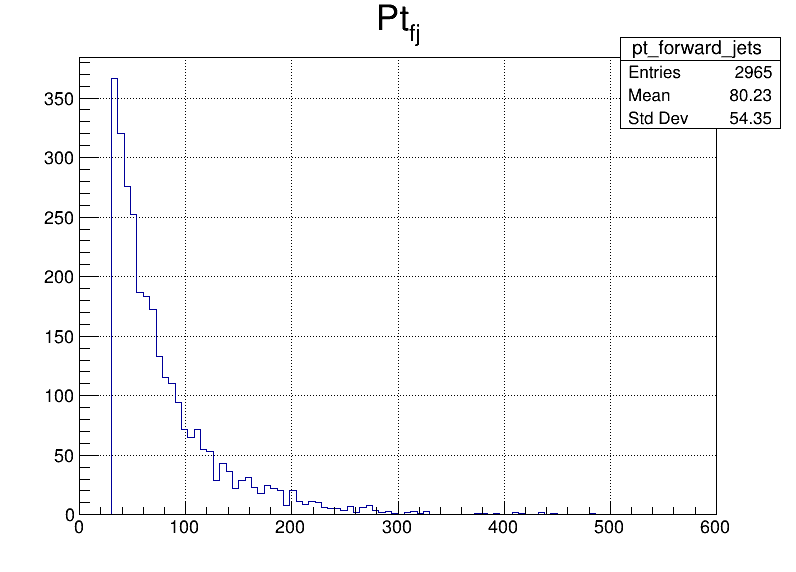

In [ ]:
pt_forward_jets.Draw()
canvas.Draw()

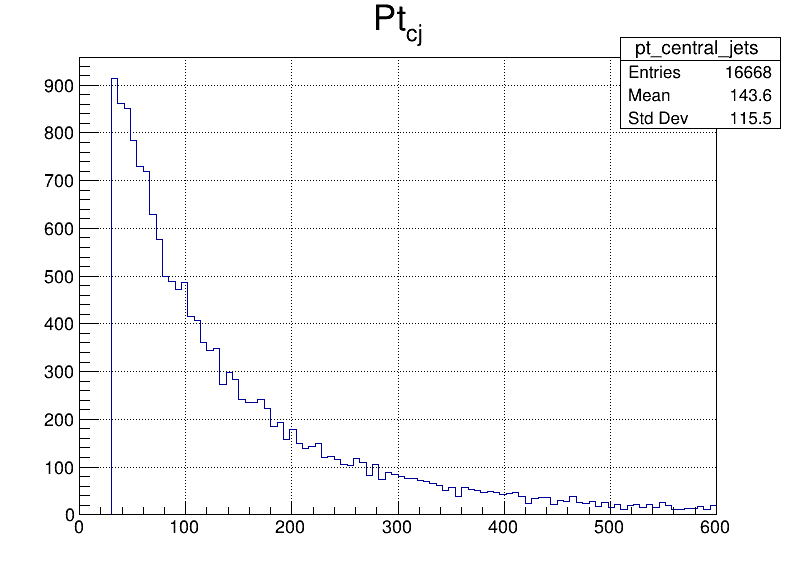

In [ ]:
pt_central_jets.Draw()
canvas.Draw()

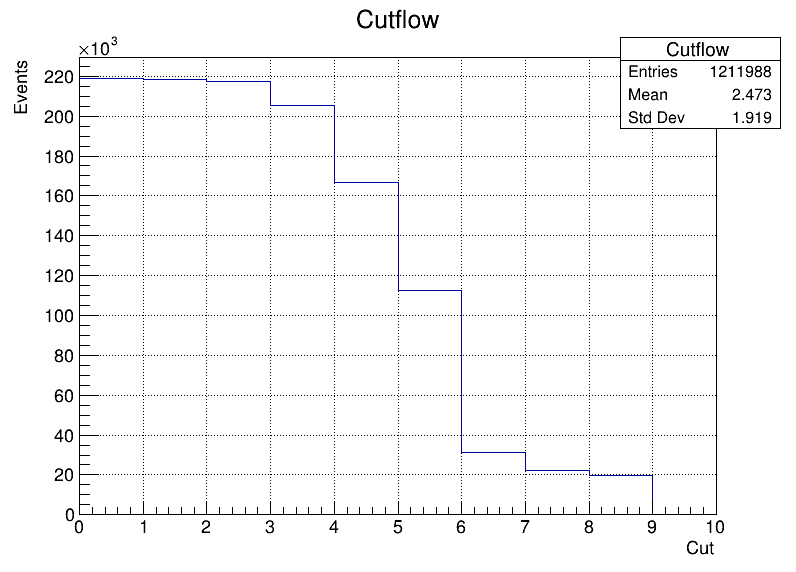

In [ ]:
cutflow.Draw()
canvas.Draw()

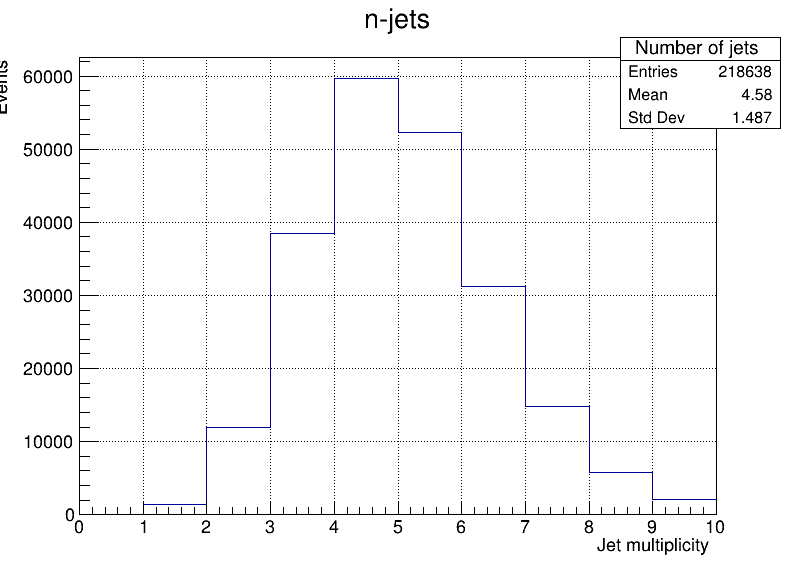

In [ ]:
hist_njets.Draw()
canvas.Draw()

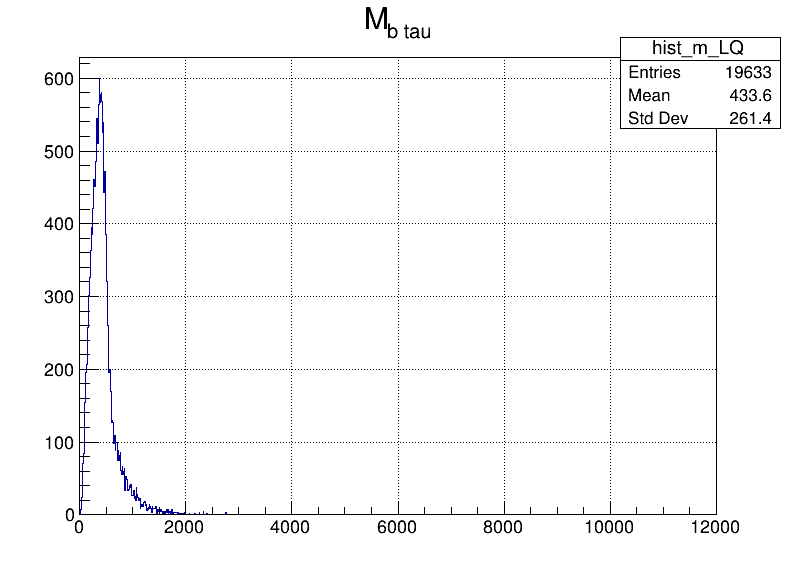

In [ ]:
hist_m_LQ.Draw()
canvas.Draw()

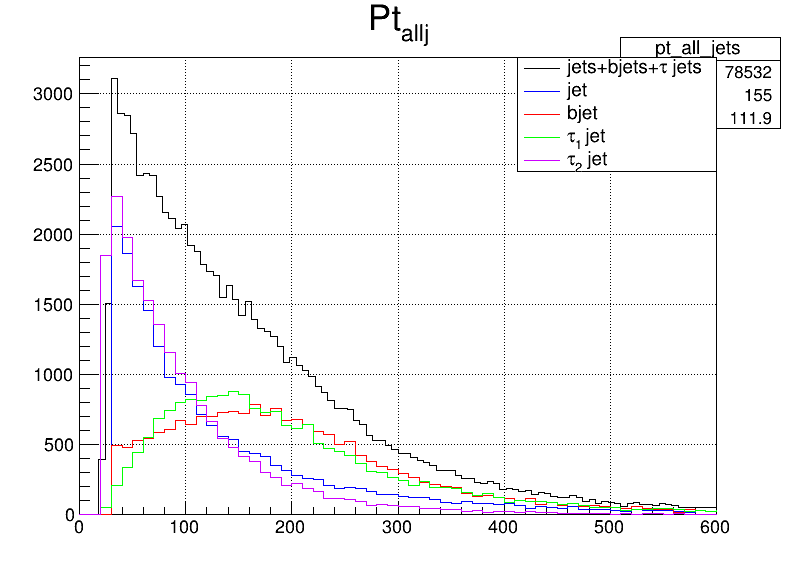

In [ ]:
pt_all_jets.Draw("HIST")
pt_lead_jets.Draw("histsame")
pt_lead_bjets.Draw("histsame")
pt_lead_taus.Draw("histsame")
pt_slead_taus.Draw("histsame")

leg=ROOT.TLegend(0.9,0.9,0.65,0.70)
leg.AddEntry("pt_all_jets", "jets+bjets+#tau jets", "l")
leg.AddEntry("pt_lead_jets", "jet", "l")
leg.AddEntry("pt_lead_bjets", "bjet", "l")
leg.AddEntry("pt_lead_taus", "#tau_{1} jet", "l")
leg.AddEntry("pt_slead_taus", "#tau_{2} jet", "l")
leg.Draw()

canvas.Draw()

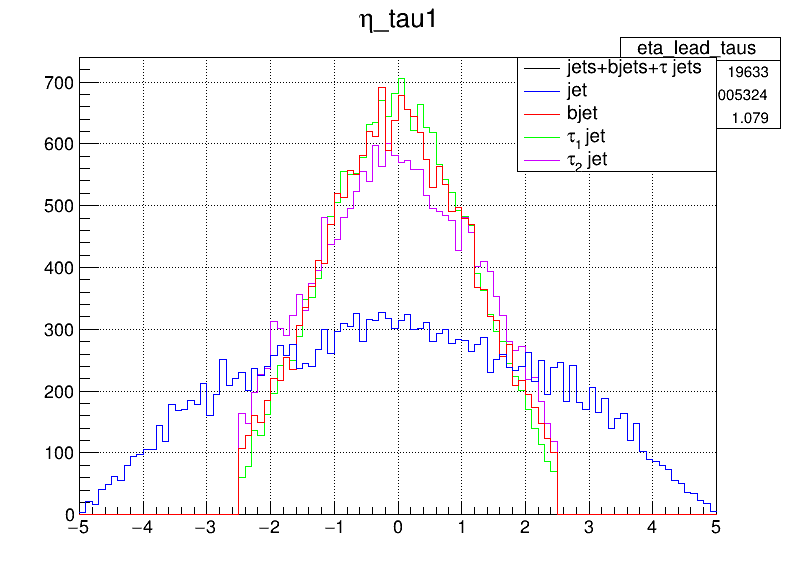

In [ ]:
#eta_all_jets.Draw("HIST")
eta_lead_taus.Draw("hist")
eta_slead_taus.Draw("histsame")
eta_lead_bjets.Draw("histsame")
eta_lead_jets.Draw("histsame")
leg=ROOT.TLegend(0.9,0.9,0.65,0.70)
leg.AddEntry("eta_all_jets", "jets+bjets+#tau jets", "l")
leg.AddEntry("eta_lead_jets", "jet", "l")
leg.AddEntry("eta_lead_bjets", "bjet", "l")
leg.AddEntry("eta_lead_taus", "#tau_{1} jet", "l")
leg.AddEntry("eta_slead_taus", "#tau_{2} jet", "l")
leg.Draw()
canvas.Draw()

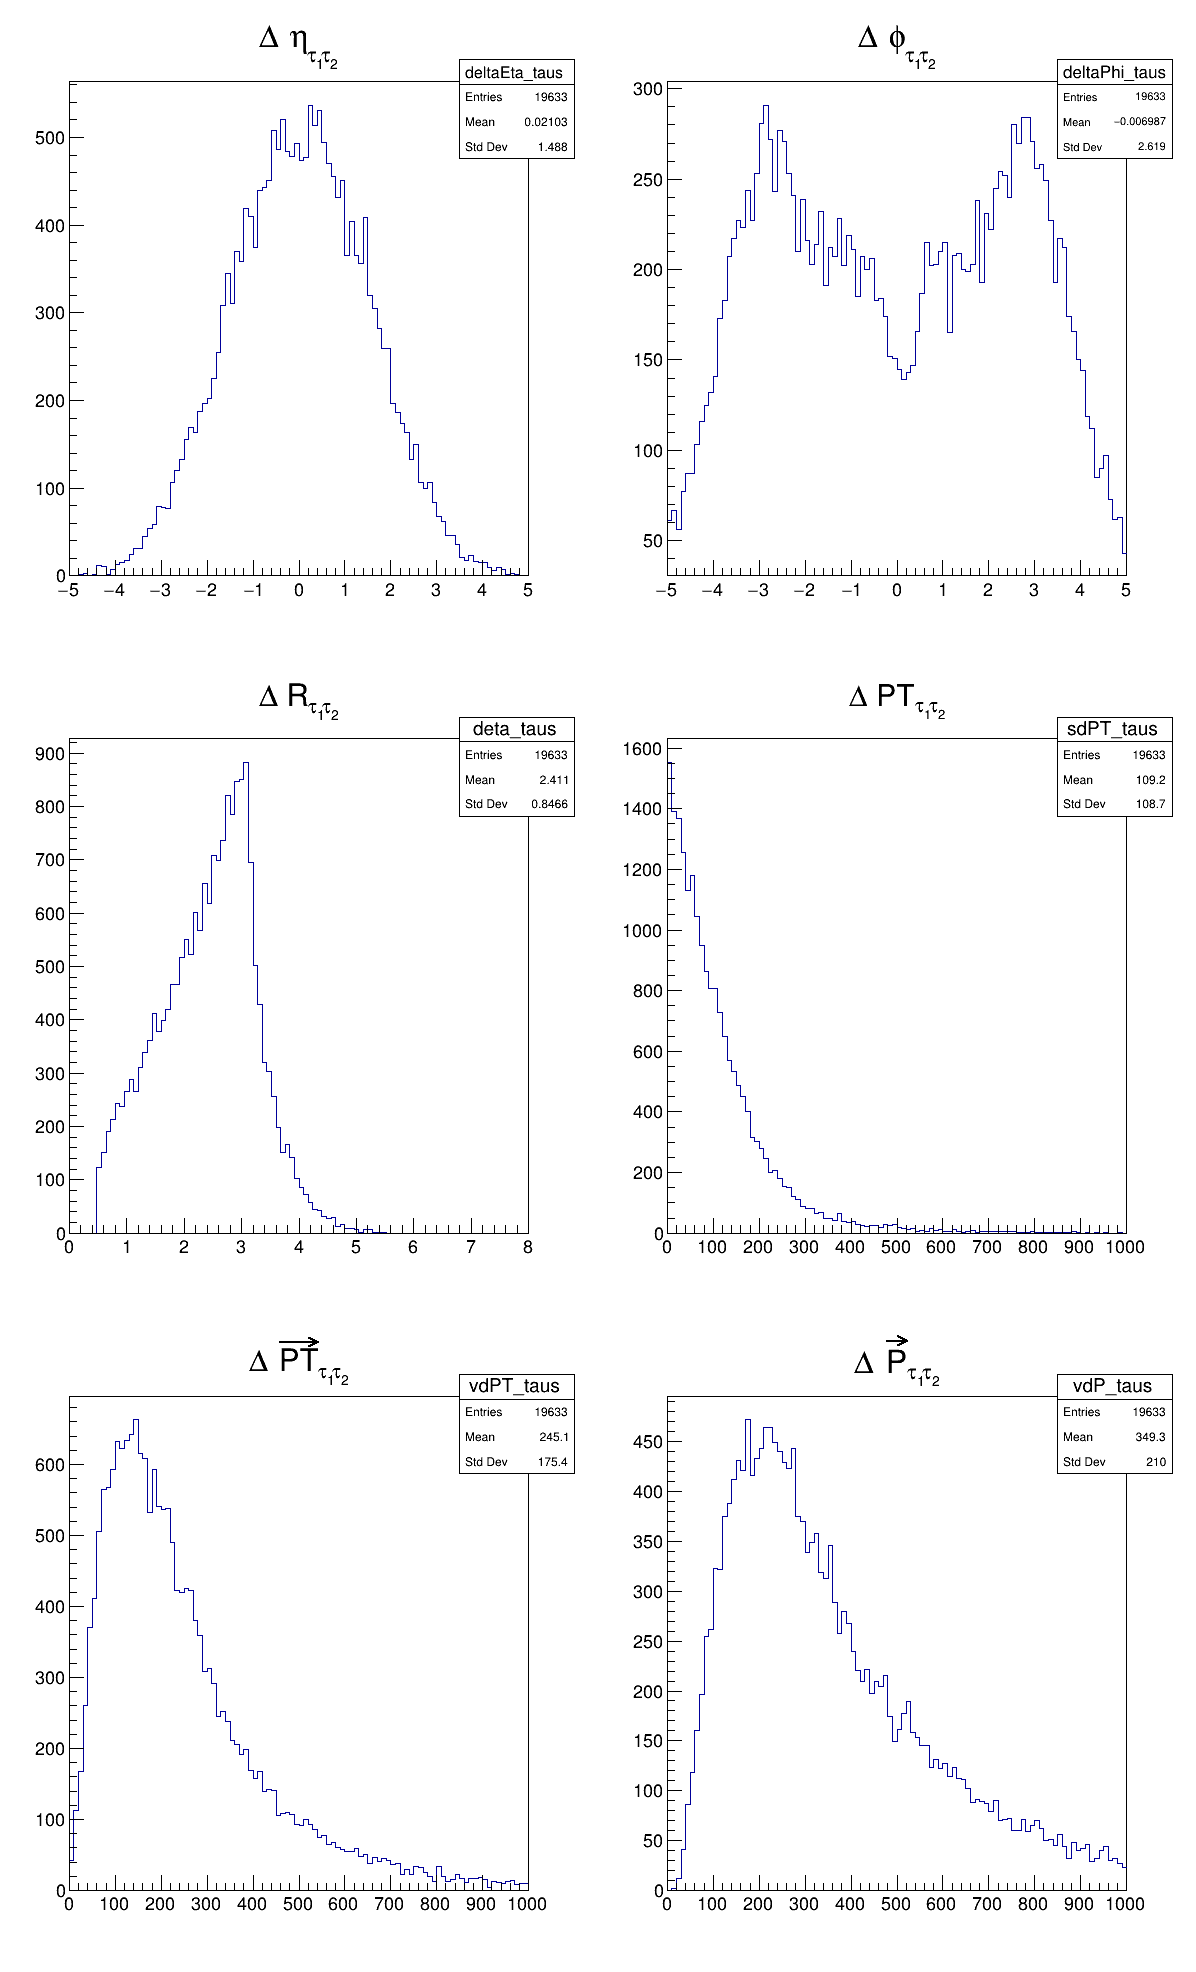

In [ ]:
scanvas = TCanvas("SCanvas","",1200,2000)
scanvas.Divide(2,3)
scanvas.cd(1)
hist_deltaEta_taus.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_taus.Draw("hist")
scanvas.cd(3)
hist_deltar_taus.Draw("hist")
scanvas.cd(4)
hist_sdPT_taus.Draw("hist")
scanvas.cd(5)
hist_vdPT_taus.Draw("hist")
scanvas.cd(6)
hist_vdP_taus.Draw("hist")
scanvas.Draw()

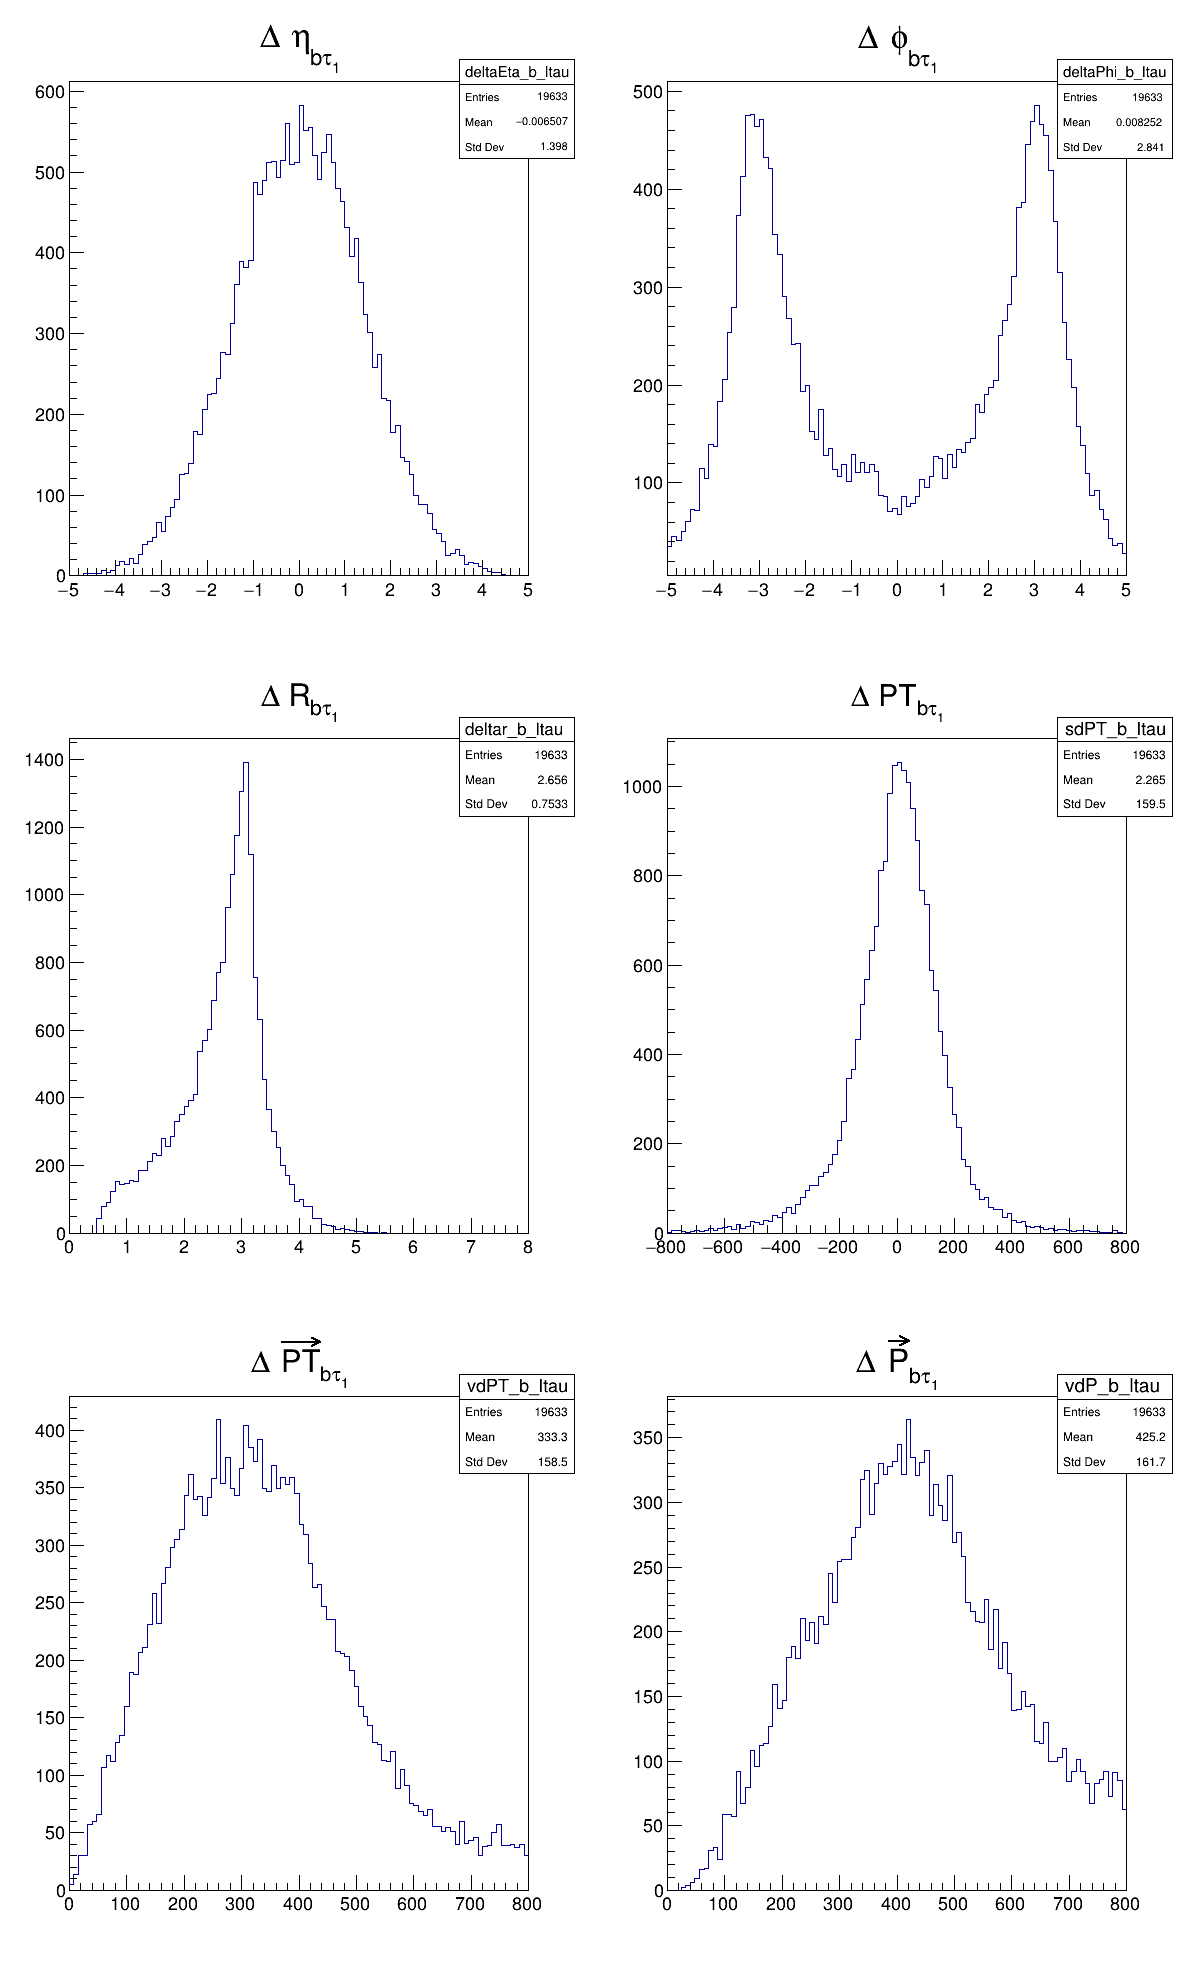

In [ ]:
scanvas.cd(1)
hist_deltaEta_b_ltau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_ltau.Draw("hist")
scanvas.cd(3)
hist_deltar_b_ltau.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_ltau.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_ltau.Draw("hist")
scanvas.cd(6)
hist_vdP_b_ltau.Draw("hist")

scanvas.Draw()

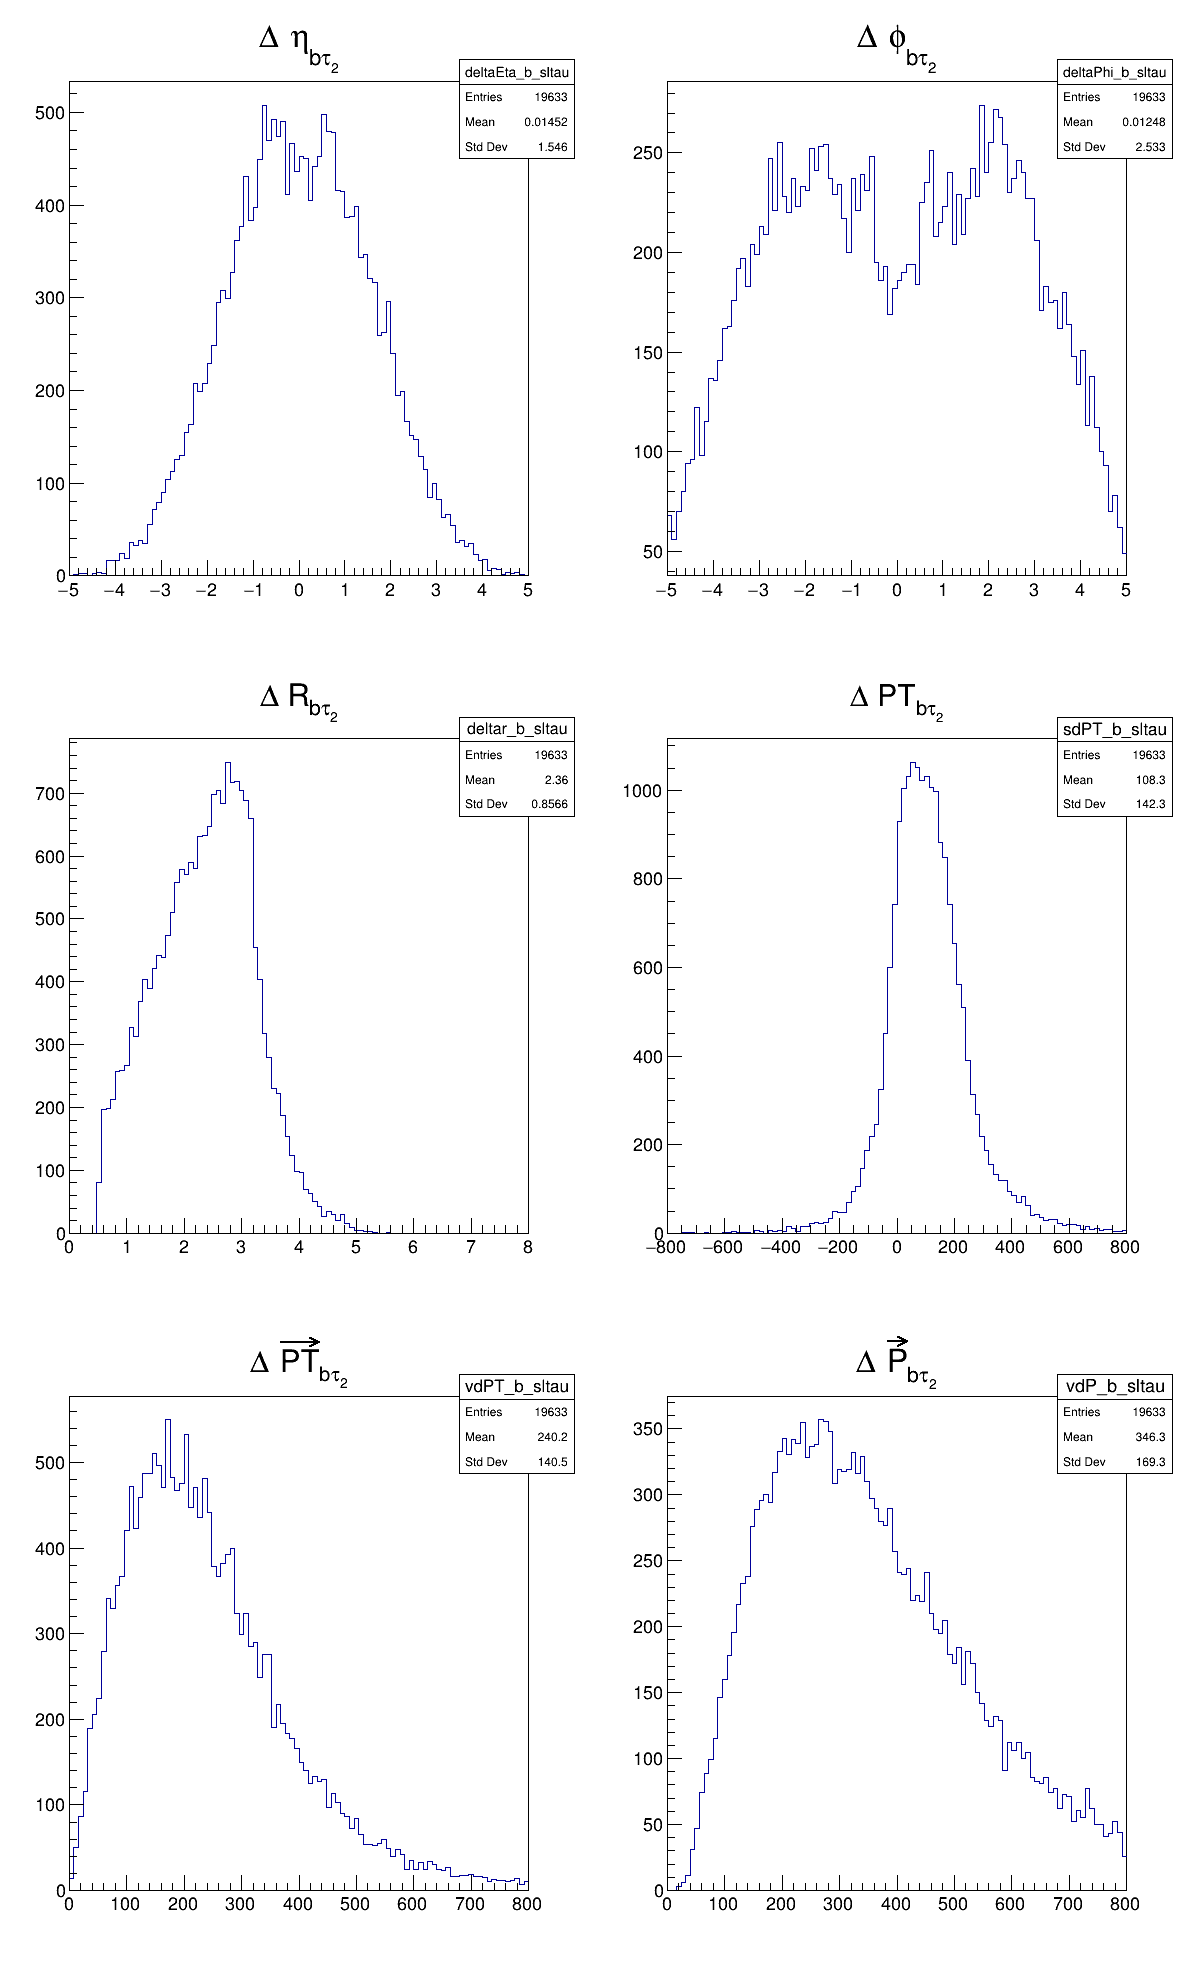

In [ ]:
scanvas.cd(1)
hist_deltaEta_b_sltau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_sltau.Draw("hist")
scanvas.cd(3)
hist_deltar_b_sltau.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_sltau.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_sltau.Draw("hist")
scanvas.cd(6)
hist_vdP_b_sltau.Draw("hist")

scanvas.Draw()

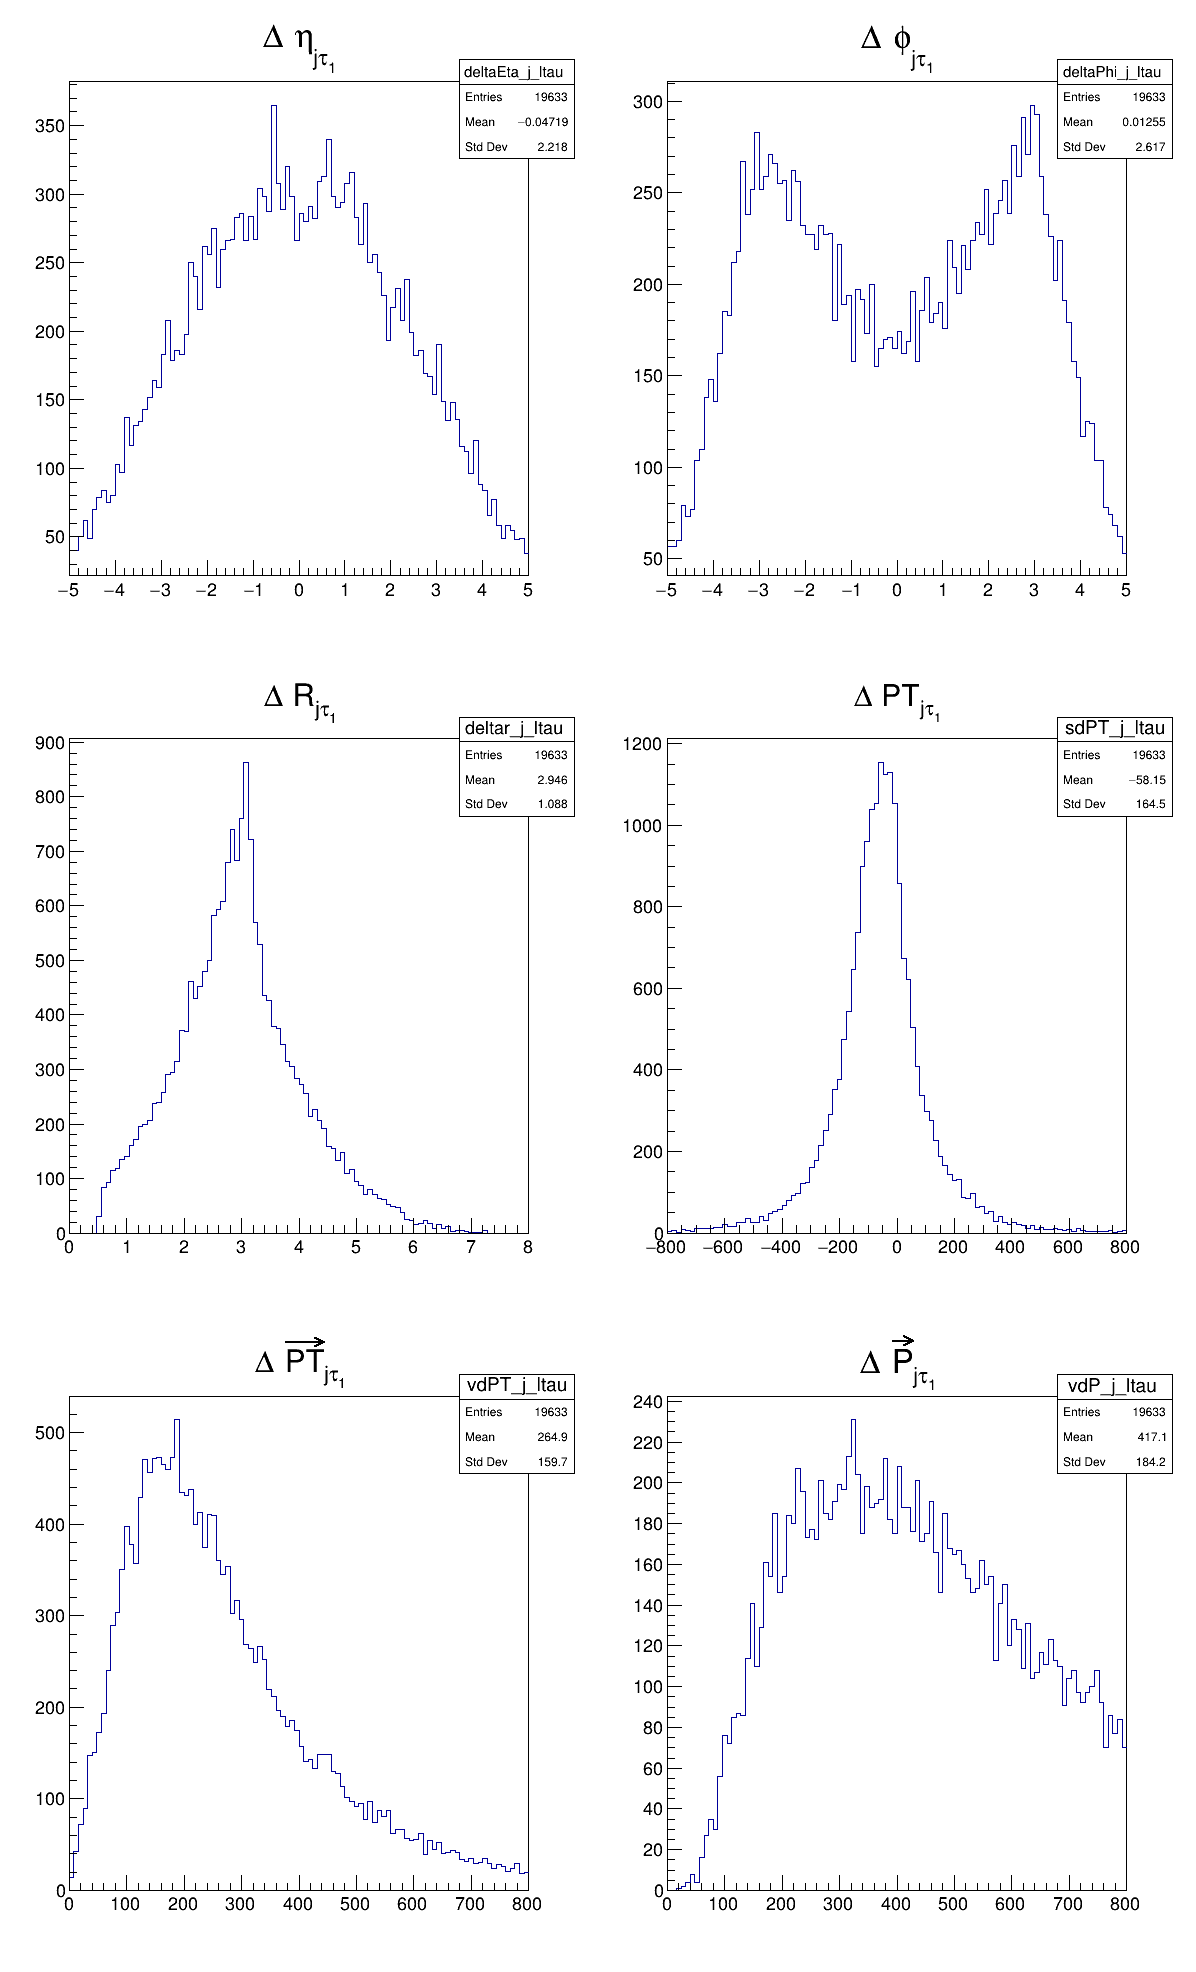

In [ ]:
scanvas.cd(1)
hist_deltaEta_j_ltau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_j_ltau.Draw("hist")
scanvas.cd(3)
hist_deltar_j_ltau.Draw("hist")
scanvas.cd(4)
hist_sdPT_j_ltau.Draw("hist")
scanvas.cd(5)
hist_vdPT_j_ltau.Draw("hist")
scanvas.cd(6)
hist_vdP_j_ltau.Draw("hist")
scanvas.Draw()

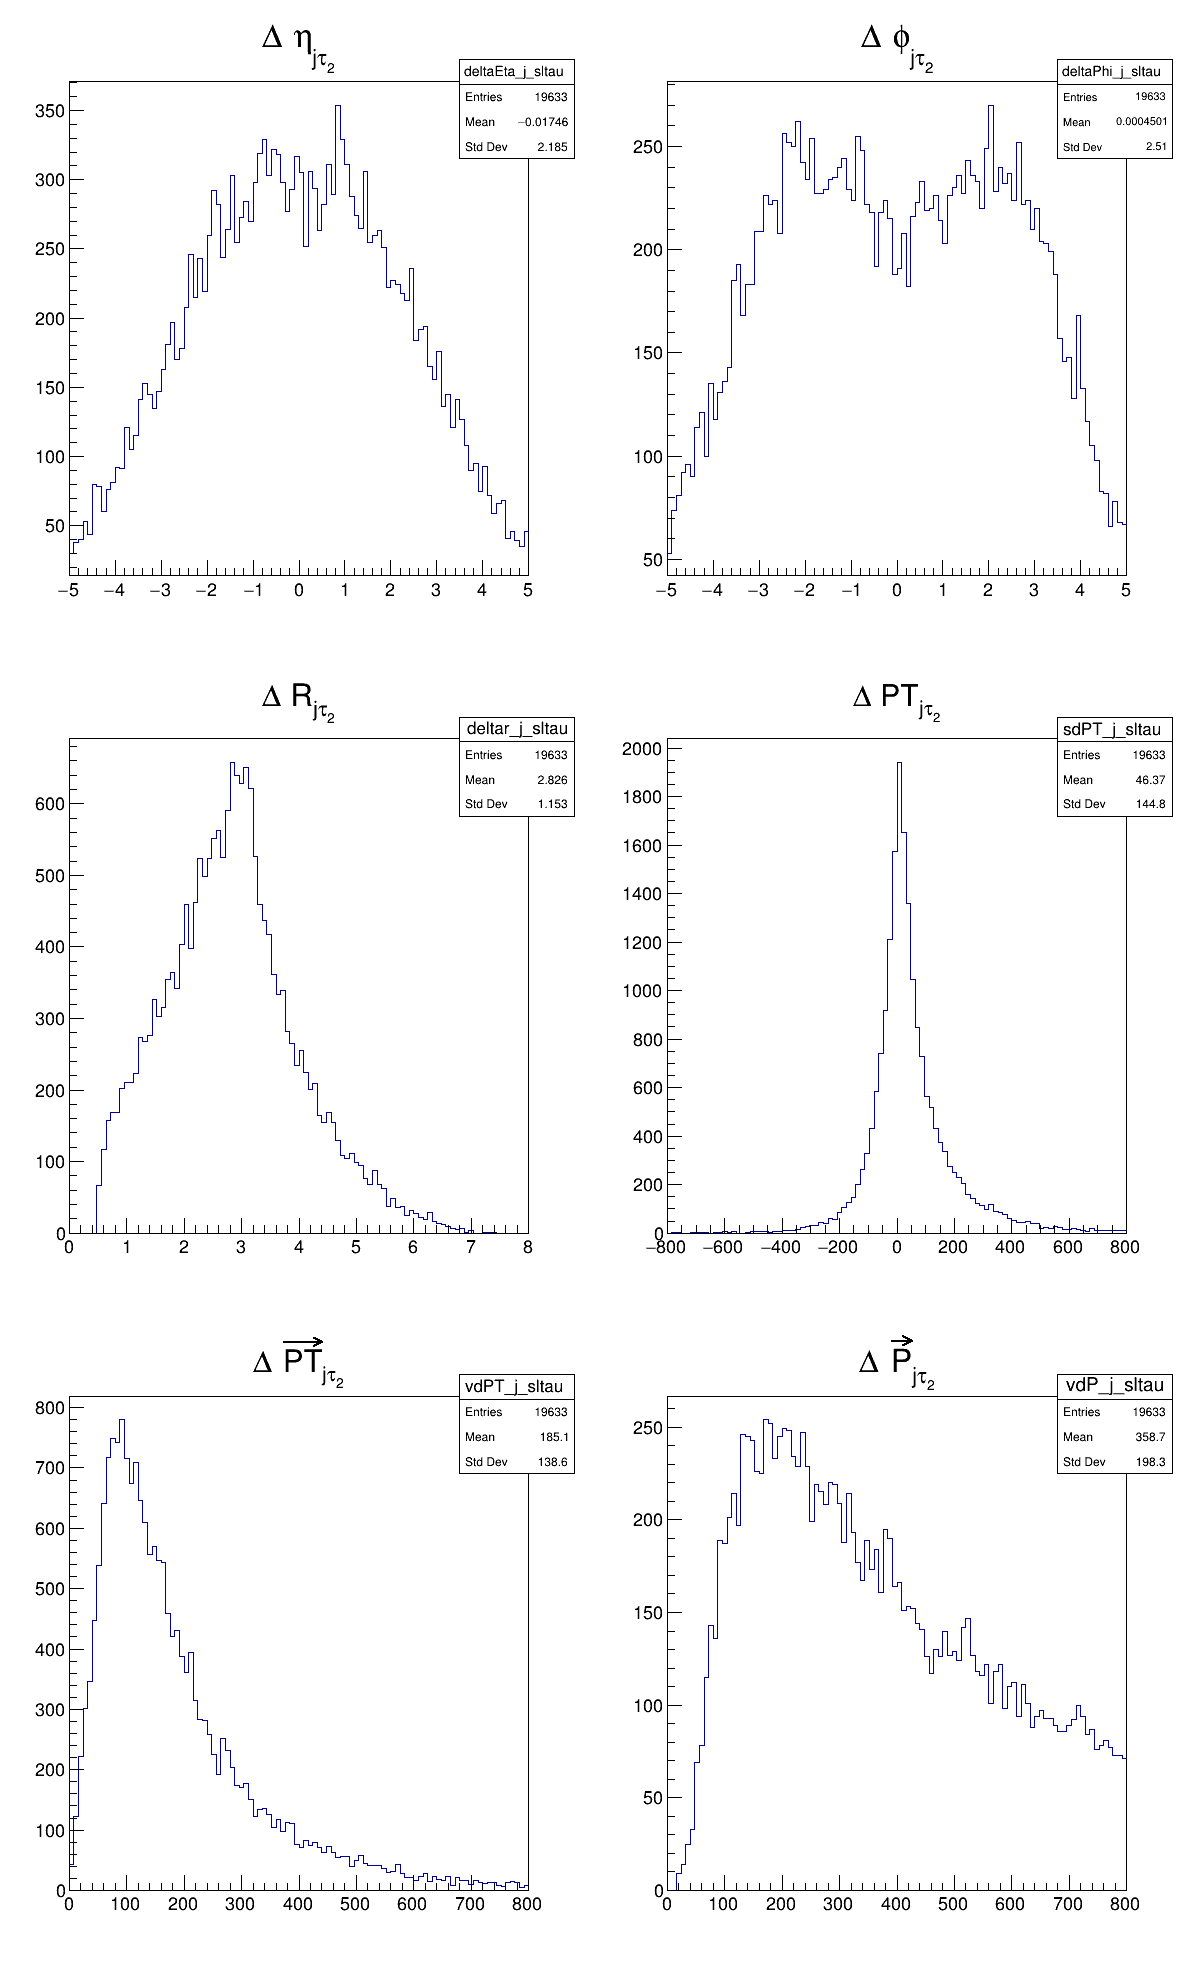

In [ ]:
scanvas.cd(1)
hist_deltaEta_j_sltau.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_j_sltau.Draw("hist")
scanvas.cd(3)
hist_deltar_j_sltau.Draw("hist")
scanvas.cd(4)
hist_sdPT_j_sltau.Draw("hist")
scanvas.cd(5)
hist_vdPT_j_sltau.Draw("hist")
scanvas.cd(6)
hist_vdP_j_sltau.Draw("hist")
scanvas.Draw()

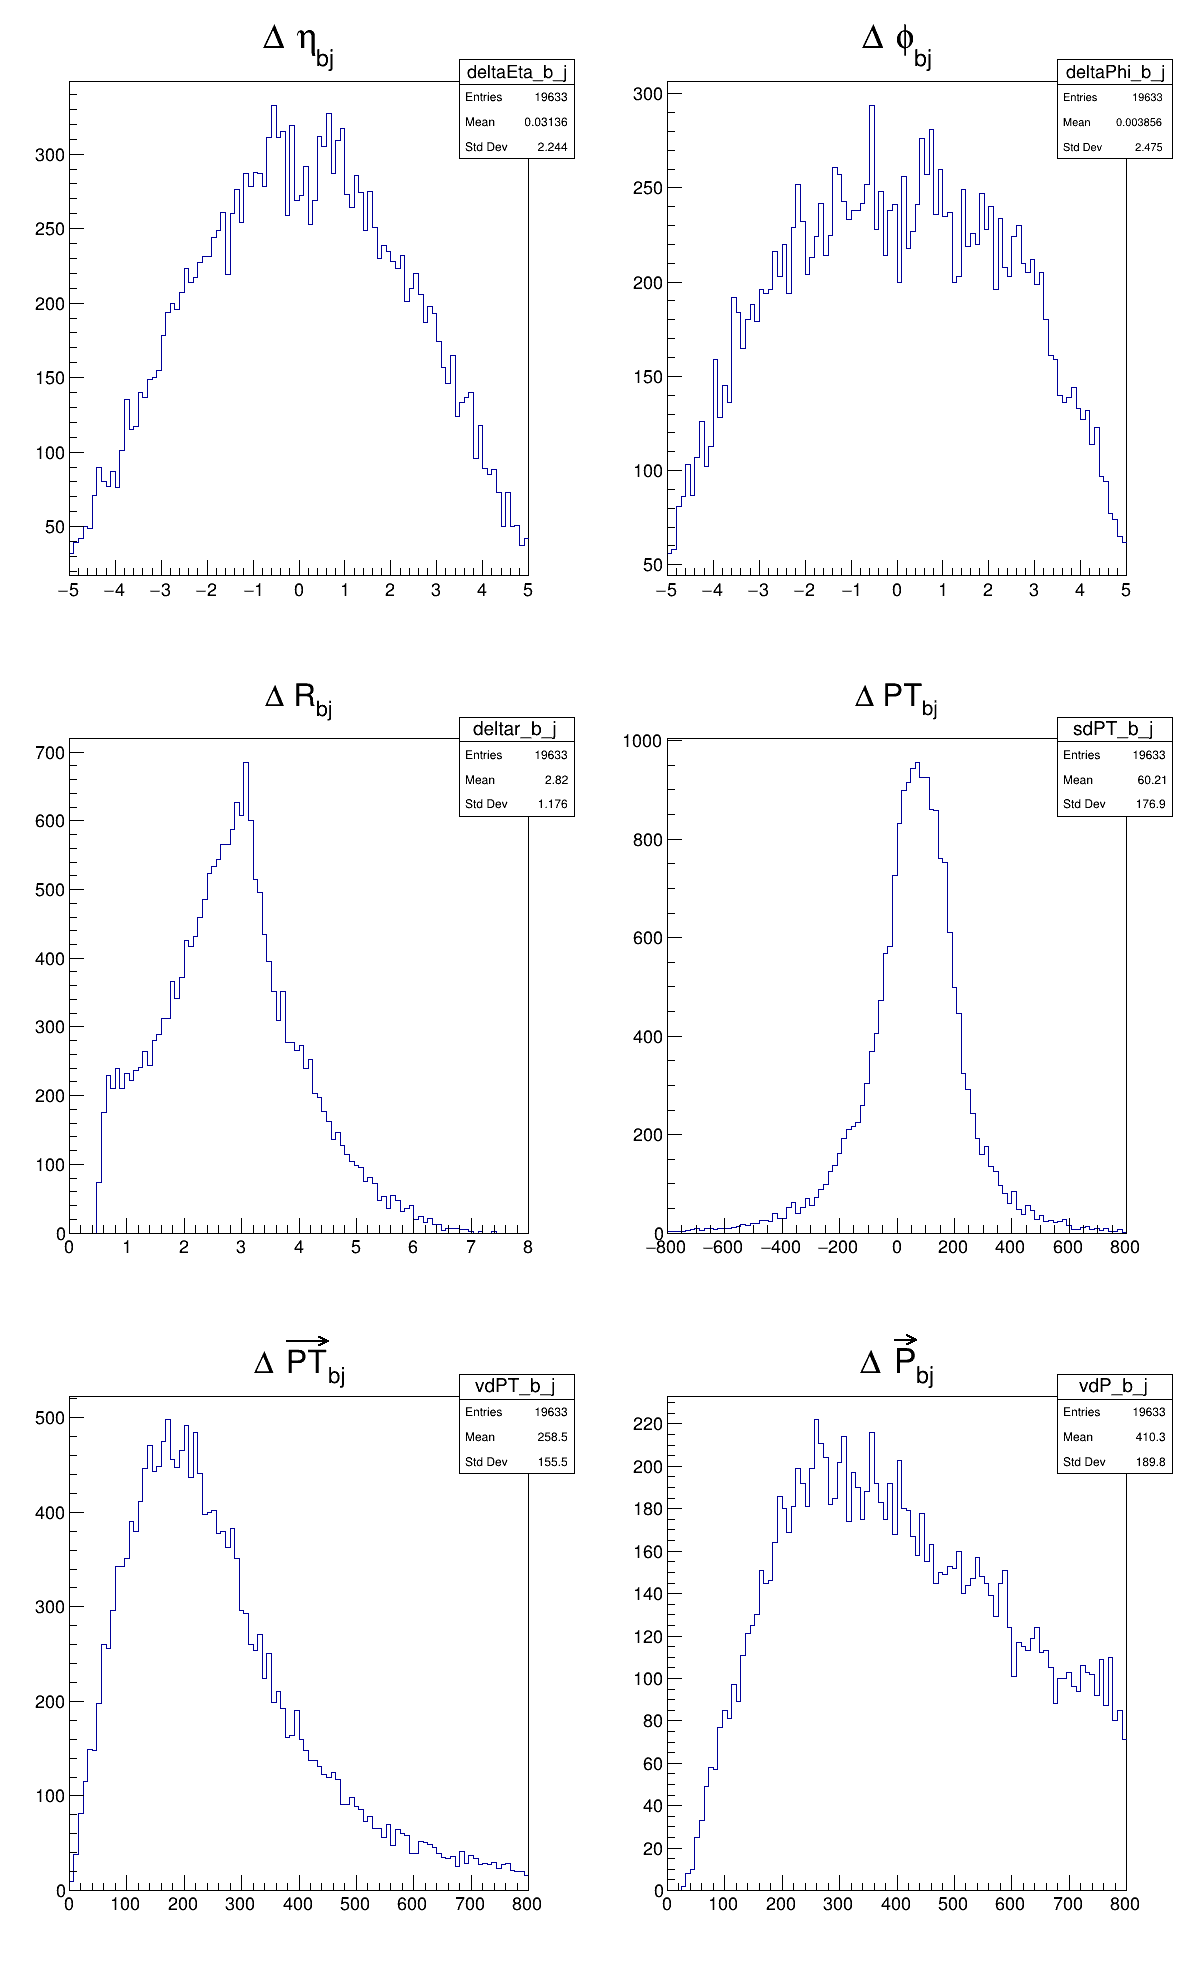

In [ ]:
scanvas.cd(1)
hist_deltaEta_b_j.Draw("hist")
scanvas.cd(2)
hist_deltaPhi_b_j.Draw("hist")
scanvas.cd(3)
hist_deltar_b_j.Draw("hist")
scanvas.cd(4)
hist_sdPT_b_j.Draw("hist")
scanvas.cd(5)
hist_vdPT_b_j.Draw("hist")
scanvas.cd(6)
hist_vdP_b_j.Draw("hist")
scanvas.Draw()